In [2]:
!unzip ./data.zip -d images

In [ ]:
# %conda install -c conda-forge ipywidgets
# %jupyter nbextension enable --py widgetsnbextension

In [3]:
# %pip install tqdm
# %pip install numpy
# %pip install pandas
# %pip install torch

In [1]:
from tqdm import tqdm

In [2]:
import argparse
import json
import string
import os
import shutil
import uuid
#from captcha.image import ImageCaptcha

import itertools

# import cv2
import numpy as np
from random import random, randint, choices

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

In [7]:
# alphabet_all = list('qwertyupasdfghjkzxcvbnm23456789QWERTYUPKJHGFDSAZXCVBNM')
# alphabet = list('qwertyupasdfghjkzxcvbnm23456789')#QWERTYUIOPLKJHGFDSAZXCVBNM')
# num_alphabet = len(alphabet)
# def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
#     if os.path.exists(img_dir):
#         shutil.rmtree(img_dir)
#     if not os.path.exists(img_dir):
#         os.makedirs(img_dir)

#     image = ImageCaptcha(width=width, height=height)

#     for counter in range(num_of_repetition):
#         i = choices(alphabet_all, k=5)
#         captcha = ''.join(i)
#         fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
#         image.write(captcha, fn)


# def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
#     _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
#     print('Finished Data Generation')

In [8]:
# BATCH_SIZE = 16
# NUM_OF_LETTERS = 5
# EPOCHS = 50
# IMG_ROW, IMG_COLS = 50, 135

# # Non-configs
# PATH = os.getcwd()
# DATA_PATH = os.path.join(PATH, 'train') # if it's on colab, then the path will be DATA_PATH.
# #DATA_PATH = "C:\\Users\\Victor\\Desktop" # this path is on my local environment where the image captchas are located

In [9]:
# # generate captcha 
# if not os.path.exists(DATA_PATH):
#     print('Generating Dataset')
#     gen_dataset(DATA_PATH, 100*1000 , NUM_OF_LETTERS, IMG_COLS, IMG_ROW)

In [4]:
# use 100000 images with 80/20 split
real_path = "/home/shubos2/final project/images/train" # here please adjust the path/directory of the data!
#real_path = real_path.replace('\\','/') 
image_names = os.listdir(real_path) # load file names for all image captchas
# Below I used 5000 images for the progress report, which took me more than 2 hours to complete it.
# to check if the code works and save time, please use a small sample size (e.g. 200 images)
image_names_train, image_names_test = train_test_split(image_names[0:100000], test_size = 0.2, train_size = 0.8, random_state=0, shuffle=True)
print(len(image_names_train), len(image_names_test))

80000 20000


In [5]:
image_text = [image_name.split("_")[0] for image_name in image_names]
image_text = "".join(image_text)
letters = sorted(list(set(list(image_text))))
#print(letters)
vocabulary = ["-"] + letters # for indexing and CTC loss ---> adding "-" is necessary!
#print(len(vocabulary))
#print(vocabulary)
idx_to_char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx_to_char)
char_to_idx = {v:k for k,v in idx_to_char.items()}
print(char_to_idx)
num_chars = len(char_to_idx) # the number of classes/features
print(num_chars)

{0: '-', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: 'A', 10: 'B', 11: 'C', 12: 'D', 13: 'E', 14: 'F', 15: 'G', 16: 'H', 17: 'J', 18: 'K', 19: 'M', 20: 'N', 21: 'P', 22: 'Q', 23: 'R', 24: 'S', 25: 'T', 26: 'U', 27: 'V', 28: 'W', 29: 'X', 30: 'Y', 31: 'Z', 32: 'a', 33: 'b', 34: 'c', 35: 'd', 36: 'e', 37: 'f', 38: 'g', 39: 'h', 40: 'j', 41: 'k', 42: 'm', 43: 'n', 44: 'p', 45: 'q', 46: 'r', 47: 's', 48: 't', 49: 'u', 50: 'v', 51: 'w', 52: 'x', 53: 'y', 54: 'z'}
{'-': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8, 'A': 9, 'B': 10, 'C': 11, 'D': 12, 'E': 13, 'F': 14, 'G': 15, 'H': 16, 'J': 17, 'K': 18, 'M': 19, 'N': 20, 'P': 21, 'Q': 22, 'R': 23, 'S': 24, 'T': 25, 'U': 26, 'V': 27, 'W': 28, 'X': 29, 'Y': 30, 'Z': 31, 'a': 32, 'b': 33, 'c': 34, 'd': 35, 'e': 36, 'f': 37, 'g': 38, 'h': 39, 'j': 40, 'k': 41, 'm': 42, 'n': 43, 'p': 44, 'q': 45, 'r': 46, 's': 47, 't': 48, 'u': 49, 'v': 50, 'w': 51, 'x': 52, 'y': 53, 'z': 54}
55


In [6]:
class load_captcha(Dataset):
    
    def __init__(self, real_path, image_names):
        self.data_dir = real_path
        self.image_names = image_names
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image_name = self.image_names[index]
        real_path = self.data_dir + '/' + image_name
        image_path = real_path.replace('\\','/')  # please replace this line with your own path!
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        text = image_name.split("_")[0] # return the 5-letter captcha (string)
        return image, text
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [13]:
# # check the size of one image output & debug
# my_input = image_names_train[0:1]
# my_train=load_captcha(real_path, my_input) 
# #print(DataLoader(my_train))
# my_train_loader = DataLoader(my_train, shuffle=True)
# my_output=my_train.__getitem__(0)[0]
# print(my_output)

In [7]:
batch_size = 32
# data loader using pytorch
trainset = load_captcha(real_path, image_names_train) 
testset = load_captcha(real_path, image_names_test)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
print(len(train_loader), len(test_loader))

2500 625


In [8]:
# get loaded data with a defined batch size using iter().next()
image_train, text_train = iter(train_loader).next()
image_test, text_test = iter(test_loader).next()
print(image_train.size(), text_train, image_test.size(), text_test)

torch.Size([32, 3, 50, 135]) ('bSrJc', '2uVS7', 'SkbF8', 'DD9Zk', 'nzU7z', 'nhBEM', 'mRcps', 'GMWWB', 'b3sQz', 'GcchA', '8MHGp', 'WWZqT', 'SMeYv', 'sdYHM', 'kyXAt', 'amMZv', 'suA2s', '2kzau', 'Z7v6Y', 'bCsgz', 'p6meH', 'QkjE2', 'X7uzR', 'MHWDW', 'qFFvn', 'ZbuQu', '3Tqsj', 'JNvrT', '5zdvn', 'G4cZv', 'RTFKE', 'zTtdj') torch.Size([32, 3, 50, 135]) ('6vCUT', 'gbbzs', 'dSEx4', 'kvEYx', 'xY4AD', 'xq3nz', 'Ska6s', 'MUpkU', 'kDHg9', 'kTagr', 'Dp9z4', '2NUZX', 'n96Bh', 'sScNW', 'C78WE', 'ZZGkC', 'Gr3SM', '23eNx', 'SWa5c', 'Duesu', 'PVpB8', 'SN2PS', 'XKd8B', 'dKtMA', 'xJsFX', 'XHNEr', 'aEvJu', '6H9yu', 'Zeesa', 'pfpN7', 'pKz3N', 'FSZet')


In [9]:
resnet = resnet18(pretrained=True)
#list(resnet.children())

In [10]:
# CRNN model based on https://github.com/abhishekkrthakur/captcha-recognition-pytorch/blob/master/model.py ,
# https://actamachina.com/notebooks/2019/03/28/captcha.html ,
# https://github.com/shishishu/pytorch-captcha-recognition ,
# https://github.com/GokulKarthik/Deep-Learning-Projects.pytorch/blob/master/5-Captcha-Text-Recognition-With-CRNN.ipynb ,
# https://www.kaggle.com/shawon10/captcha-recognition and
# https://github.com/DrMahdiRezaei/Deep-CAPTCHA/blob/master/Captcha_Solver_numerical.ipynb
class captcha_CRNN1(nn.Module):

    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        super(captcha_CRNN1, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        resnet_modules = list(resnet.children())[:-3] # --> remove the last three modules (1 nn.sequential, 1 avg_pool and 1 linear)
        self.cnn1 = nn.Sequential(*resnet_modules)
        self.cnn2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, hidden_size=rnn_hidden_size, bidirectional=True, batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, hidden_size=rnn_hidden_size, bidirectional=True, batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars) # bidirection = T so multiply by 2
    
    def forward(self, x): # for 16 batches data
        x = self.cnn1(x) # torch.Size([16, 256, 4, 9])
        #print(x.size()) 
        x = self.cnn2(x) # torch.Size([16, 256, 4, 6]) [batch_size, channels, height, width]
        #print(x.size()) 
        x = x.permute(0, 3, 1, 2) # torch.Size([16, 6, 256, 4])  [batch_size, width, channels, height]
        #print(x.size()) 
        batch_size = x.size(0)
        T = x.size(1) # time length
        x = x.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        #print(x.size()) # torch.Size([-1, T, 1024]) ---> torch.Size([16, 6, 1024])
        x = self.linear1(x)
        #print(x.size()) # torch.Size([-1, T, 256]) ---> torch.Size([16, 6, 256])
        x, hidden = self.rnn1(x)
        feature_size = x.size(2) # torch.Size([16, 6, 256*2])
        x = x[:, :, :feature_size//2] + x[:, :, feature_size//2:] # torch.Size([16, 6, 256]) 
        #print(x.size())
        x, hidden = self.rnn2(x) # torch.Size([16, 6, 512])
        #print(x.size()) 
        x = self.linear2(x) # torch.Size([-1, T, num_features]) ---> torch.Size([16, 6, 55])
        #print(x.size()) 
        x = x.permute(1, 0, 2) # [T, batch_size, num_features] for CTC loss training
        #print(x.size()) # torch.Size([6, 16, 55]) ---> batch_size has to be in the middle!
        return x

In [11]:
# weight matrices application using https://github.com/GokulKarthik/Deep-Learning-Projects.pytorch/blob/master/5-Captcha-Text-Recognition-With-CRNN.ipynb
def weights_init(m): 
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight) 
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [12]:
crnn = captcha_CRNN1(num_chars=num_chars,rnn_hidden_size=256)
crnn.apply(weights_init)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
crnn = crnn.to(device)
#crnn
#processed_label_train = crnn(image_train.to(device))
#print(processed_label_train)
#processed_label_train.size() # torch.Size([6, 16, 55])

In [14]:
def encode_captcha(text_captcha):
    text_lens = [len(text) for text in text_captcha]
    text_lens = torch.IntTensor(text_lens)
    text_raw = "".join(text_captcha)
    text_encoded = [char_to_idx[text] for text in text_raw]
    text_encoded = torch.IntTensor(text_encoded)
    return text_encoded, text_lens

def decode_predictions(text_encoded):
    pred_decoded = F.softmax(text_encoded, 2).argmax(2) # [T, batch_size] --> return the column number of the max for each row 
    pred_decoded = pred_decoded.numpy().T # [batch_size, T]
    pred_decoded_new = []
    for labels in pred_decoded:
        text = [idx_to_char[idx] for idx in labels]
        text = "".join(text)
        pred_decoded_new.append(text)
    return pred_decoded_new

#aa=F.softmax(processed_label_train, 2).argmax(2)
#print(aa.numpy().T)
#decode_predictions(processed_label_train)
def loss_captcha(targets, outputs):
    # targets: raw 5-letter text / outputs: # [T, batch_size, num_features]
    outputs = F.log_softmax(outputs, 2) # [T, batch_size, num_features]  
    outputs_lens = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.int32).to(device) # a [] containing the batch size of 6 
    #print(outputs.shape)
    #print(outputs_lens) 
    text_encoded, targets_lens = encode_captcha(targets)
    #print(text_encoded)
    #print(targets_lens) ---> a [] containing the batch size of 5 
    loss = criterion(outputs, text_encoded, outputs_lens, targets_lens) # CTC loss
    return loss

criterion = nn.CTCLoss()
optimizer = optim.Adam(crnn.parameters(), lr=0.001, weight_decay=0.001)
# reduce the learning rate when the model stops improving; patience=5 means no reduction on the learning rate during the first 5 epochs.
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5) 
# here we use 20 epochs and 16 batch_size to train the training data (400 images) to see if it works
epochs = 100
result_loss = []
iter_loss = []
num_epoch_update = []

In [15]:
for epoch in tqdm(range(epochs)):
    epoch_loss_list = []
    current_update = 0
    for image_train, label_train in tqdm(train_loader, leave=False): 
        optimizer.zero_grad() # clear gradient for every x
        label_train_crnn = crnn(image_train.to(device))
        loss = loss_captcha(label_train, label_train_crnn)
        loss_current = loss.item() # extract the value of loss for the current batch
        if np.isnan(loss_current) or np.isinf(loss_current):
            continue
        current_update += 1
        iter_loss.append(loss_current)
        epoch_loss_list.append(loss_current)
        loss.backward() # backprop
        nn.utils.clip_grad_norm_(parameters = crnn.parameters(), max_norm = 5) # gradient clipping to prevent the gradient exploding using p2 norm
        optimizer.step() # parameter update 
    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, current_update))
    result_loss.append(epoch_loss)
    num_epoch_update.append(current_update)
    lr_scheduler.step(epoch_loss) # adjust the learning rate

  0%|          | 2/2500 [00:00<02:43, 15.31it/s]

Epoch:0    Loss:3.0720530532836916    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:50, 14.67it/s]

Epoch:1    Loss:0.9789862483501435    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:47, 14.93it/s]

Epoch:2    Loss:0.6367542957186699    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.33it/s]

Epoch:3    Loss:0.5209457252264023    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:40, 15.53it/s]

Epoch:4    Loss:0.46741927031278613    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:39, 15.67it/s]

Epoch:5    Loss:0.4297513157725334    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:33, 16.24it/s]

Epoch:6    Loss:0.41456217988729477    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:40, 15.61it/s]

Epoch:7    Loss:0.3973319011092186    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:41, 15.43it/s]

Epoch:8    Loss:0.3882139845967293    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.39it/s]

Epoch:9    Loss:0.37932133705615995    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.40it/s]

Epoch:10    Loss:0.36988983502984046    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:41, 15.45it/s]

Epoch:11    Loss:0.36756532673835757    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:40, 15.56it/s]

Epoch:12    Loss:0.3621836547791958    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:47, 14.95it/s]

Epoch:13    Loss:0.36017815230488776    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:44, 15.19it/s]

Epoch:14    Loss:0.355463316488266    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:50, 14.63it/s]

Epoch:15    Loss:0.3558700137734413    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:37, 15.83it/s]

Epoch:16    Loss:0.3567042729020119    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:45, 15.05it/s]

Epoch:17    Loss:0.35279536618590357    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.41it/s]

Epoch:18    Loss:0.3517172740697861    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:35, 16.09it/s]

Epoch:19    Loss:0.34992727759480474    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:48, 14.82it/s]

Epoch:20    Loss:0.35065322042107583    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:35, 16.07it/s]

Epoch:21    Loss:0.3505202295422554    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:40, 15.56it/s]

Epoch:22    Loss:0.3504306772470474    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:40, 15.55it/s]

Epoch:23    Loss:0.34891958360672    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:44, 15.21it/s]

Epoch:24    Loss:0.34717614529132845    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:36, 15.92it/s]

Epoch:25    Loss:0.3458976026237011    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:43, 15.32it/s]

Epoch:26    Loss:0.34555604690909386    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:48, 14.82it/s]

Epoch:27    Loss:0.3467837542414665    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.37it/s]

Epoch:28    Loss:0.3469075010120869    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.33it/s]

Epoch:29    Loss:0.3458219174742699    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.39it/s]

Epoch:30    Loss:0.345325241792202    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:38, 15.80it/s]

Epoch:31    Loss:0.34429291544556617    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:41, 15.44it/s]

Epoch:32    Loss:0.3427566897392273    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:35, 16.06it/s]

Epoch:33    Loss:0.34374200446009634    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:39, 15.68it/s]

Epoch:34    Loss:0.34369885048270227    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:41, 15.49it/s]

Epoch:35    Loss:0.3451950337290764    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:41, 15.47it/s]

Epoch:36    Loss:0.3445204541146755    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:46, 15.00it/s]

Epoch:37    Loss:0.3431205713689327    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:40, 15.61it/s]

Epoch:38    Loss:0.34609807669520376    NumUpdates:2500
Epoch    38: reducing learning rate of group 0 to 1.0000e-04.



  0%|          | 2/2500 [00:00<02:39, 15.64it/s]

Epoch:39    Loss:0.2582947572648525    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:57, 14.03it/s]

Epoch:40    Loss:0.23565883813500405    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.33it/s]

Epoch:41    Loss:0.22638740636706353    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:40, 15.52it/s]

Epoch:42    Loss:0.22010316134095192    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:38, 15.76it/s]

Epoch:43    Loss:0.21449026533961296    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.40it/s]

Epoch:44    Loss:0.21058050309419632    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:40, 15.59it/s]

Epoch:45    Loss:0.20602714260816574    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:45, 15.08it/s]

Epoch:46    Loss:0.20187935096025467    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.33it/s]

Epoch:47    Loss:0.19818387203216553    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:41, 15.45it/s]

Epoch:48    Loss:0.19484921525120735    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:38, 15.78it/s]

Epoch:49    Loss:0.19132642650008203    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:39, 15.65it/s]

Epoch:50    Loss:0.1886059432387352    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:53, 14.39it/s]

Epoch:51    Loss:0.18638793479800225    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.38it/s]

Epoch:52    Loss:0.1841944593846798    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:56, 14.18it/s]

Epoch:53    Loss:0.18150011945962907    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:41, 15.45it/s]

Epoch:54    Loss:0.17940303660035134    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.34it/s]

Epoch:55    Loss:0.1785438924193382    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:44, 15.20it/s]

Epoch:56    Loss:0.17735957889556886    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.41it/s]

Epoch:57    Loss:0.17698333210349082    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:45, 15.14it/s]

Epoch:58    Loss:0.1761782323002815    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:43, 15.26it/s]

Epoch:59    Loss:0.1757862839102745    NumUpdates:2500



  0%|          | 2/2500 [00:00<03:40, 11.33it/s]

Epoch:60    Loss:0.17499420118927955    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:39, 15.64it/s]

Epoch:61    Loss:0.1752055033802986    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:51, 14.53it/s]

Epoch:62    Loss:0.17419426739811897    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.34it/s]

Epoch:63    Loss:0.17422313797473907    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:39, 15.66it/s]

Epoch:64    Loss:0.17365235595703124    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:47, 14.95it/s]

Epoch:65    Loss:0.17345856129527093    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:40, 15.57it/s]

Epoch:66    Loss:0.17428867704868317    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:41, 15.44it/s]

Epoch:67    Loss:0.17352226545214652    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:43, 15.24it/s]

Epoch:68    Loss:0.17321635061502458    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:43, 15.23it/s]

Epoch:69    Loss:0.17367701382637024    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:41, 15.51it/s]

Epoch:70    Loss:0.17323246554732322    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:39, 15.67it/s]

Epoch:71    Loss:0.17371072996854783    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:40, 15.54it/s]

Epoch:72    Loss:0.17406538111567496    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.39it/s]

Epoch:73    Loss:0.17360111461877822    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:44, 15.21it/s]

Epoch:74    Loss:0.17377550495564936    NumUpdates:2500
Epoch    74: reducing learning rate of group 0 to 1.0000e-05.



  0%|          | 2/2500 [00:00<02:41, 15.43it/s]

Epoch:75    Loss:0.1649911474764347    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:45, 15.06it/s]

Epoch:76    Loss:0.1625662127196789    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:40, 15.56it/s]

Epoch:77    Loss:0.16150493943095207    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:54, 14.28it/s]

Epoch:78    Loss:0.1611574035525322    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:56, 14.15it/s]

Epoch:79    Loss:0.1608214492112398    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:40, 15.56it/s]

Epoch:80    Loss:0.16054072881937026    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.37it/s]

Epoch:81    Loss:0.16027185907959937    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:48, 14.79it/s]

Epoch:82    Loss:0.16025845963954927    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:41, 15.44it/s]

Epoch:83    Loss:0.16006406841874124    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:44, 15.16it/s]

Epoch:84    Loss:0.15990618008971214    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:40, 15.57it/s]

Epoch:85    Loss:0.1599199834704399    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:46, 15.05it/s]

Epoch:86    Loss:0.1597822647213936    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:39, 15.65it/s]

Epoch:87    Loss:0.15975615781545638    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:41, 15.48it/s]

Epoch:88    Loss:0.15971849583387374    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:46, 15.05it/s]

Epoch:89    Loss:0.15966429695487022    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:39, 15.62it/s]

Epoch:90    Loss:0.15968590910434724    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:43, 15.25it/s]

Epoch:91    Loss:0.15960379808545114    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:40, 15.58it/s]

Epoch:92    Loss:0.15962160252332688    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.38it/s]

Epoch:93    Loss:0.15952297304272653    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:39, 15.71it/s]

Epoch:94    Loss:0.15954440323710442    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:41, 15.43it/s]

Epoch:95    Loss:0.1594580272257328    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:41, 15.47it/s]

Epoch:96    Loss:0.15941125177145005    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:39, 15.69it/s]

Epoch:97    Loss:0.15942347982525826    NumUpdates:2500



  0%|          | 2/2500 [00:00<02:42, 15.39it/s]

Epoch:98    Loss:0.1594284234046936    NumUpdates:2500



100%|██████████| 100/100 [4:27:04<00:00, 160.25s/it][A

Epoch:99    Loss:0.15941432732343674    NumUpdates:2500


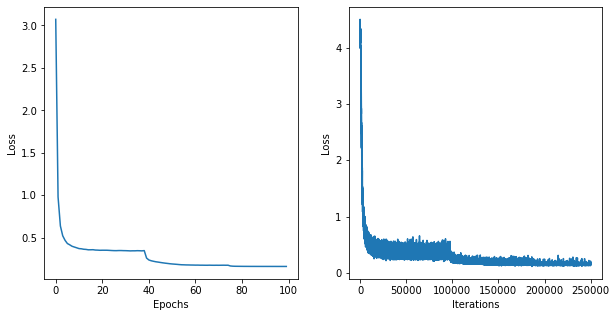

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# loss over epoch
ax1.plot(result_loss)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
# loss over iterations (images)
ax2.plot(iter_loss)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")
plt.show()

In [17]:
results_train = pd.DataFrame(columns=['true', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, shuffle=False)
with torch.no_grad(): # skipping the gradient calculation over the weights
    for image_train, text_train  in tqdm(train_loader, leave=True):
        text_encoded = crnn(image_train.to(device)) # [T, batch_size, num_classes==num_features]
        text_decoded = decode_predictions(text_encoded.cpu()) 
        df = pd.DataFrame(columns=['true', 'prediction'])
        df['true'] = text_train
        df['prediction'] = text_decoded
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)
#results_train

100%|██████████| 5000/5000 [02:03<00:00, 40.46it/s]


In [18]:
results_test = pd.DataFrame(columns=['true', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, shuffle=False)
with torch.no_grad(): # skipping the gradient calculation over the weights
    for image_test, text_test  in tqdm(test_loader, leave=True):
        text_encoded = crnn(image_test.to(device)) # [T, batch_size, num_classes==num_features]
        text_decoded = decode_predictions(text_encoded.cpu())
        df = pd.DataFrame(columns=['true', 'prediction'])
        df['true'] = text_test
        df['prediction'] = text_decoded
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)
#results_test

100%|██████████| 1250/1250 [02:22<00:00,  8.79it/s]


In [19]:
def remove_duplicates(text): 
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-") 
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

# Here some prediction texts have a length not equal to 5
results_train['correct_pred'] = results_train['prediction'].apply(correct_prediction)
results_test['correct_pred'] = results_test['prediction'].apply(correct_prediction)

In [20]:
results_train

true prediction correct_pred
0      jeY8A     jeYY8A        jeY8A
1      VDt58     VDt558        VDt58
2      7jXKA     7jXXKA        7jXKA
3      4WSvC     4WSSvC        4WSvC
4      zNthy     zNtthy        zNthy
...      ...        ...          ...
79995  3yTAd     3yTTAd        3yTAd
79996  bFS8x     bFSS8x        bFS8x
79997  XzSdW     XzSSdW        XzSdW
79998  g4B7B     g4BB7B        g4B7B
79999  rTqMA     rTqqMA        rTqMA

[80000 rows x 3 columns]

In [21]:
results_test

true prediction correct_pred
0      6vCUT     6VCCUT        6VCUT
1      gbbzs     gb-bzs        gbbzs
2      dSEx4     dSEEx4        dSEx4
3      kvEYx     kvEEYx        kvEYx
4      xY4AD     xY44AD        xY4AD
...      ...        ...          ...
19995  RG3rC     RG33rC        RG3rC
19996  fqWfg     fqWWfg        fqWfg
19997  4ENdb     4EEddb         4Edb
19998  YWwjn     YWwwjn        YWwjn
19999  zk2vC     zk22vC        zk2vC

[20000 rows x 3 columns]

In [22]:
train_incorrect_df = results_train[results_train['true'] != results_train['correct_pred']]
train_accuracy = 1 - train_incorrect_df.shape[0]/len(image_names_train)
train_error = 1 - train_accuracy
test_incorrect_df = results_test[results_test['true'] != results_test['correct_pred']]
test_accuracy = 1 - test_incorrect_df.shape[0]/len(image_names_test)
test_error = 1 - test_accuracy
print(f"Train accuracy {train_accuracy}")
print(f"Test accuracy {test_accuracy}")

Train accuracy 0.9958125
Test accuracy 0.8778


In [ ]:
#from sklearn.metrics import confusion_matrix
#confusion_matrix(results_test[“true”], results_test[“correct_pred”])
